In [1]:
# Establece las librerias del sistema
# Manejo de datos
import pandas as pd
import numpy as np
# Maejo de directorios y archivos
import os
import glob
# Librerias de pronotiscos
from statsmodels.tsa.api import SimpleExpSmoothing
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.stats.outliers_influence import summary_table
from statsmodels.tsa.seasonal import seasonal_decompose
# Advertencias del sistema
import warnings
warnings.filterwarnings('ignore')



# Funciones internas
def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
def wmape(actual, forecast):
    actual,forecast = np.array(actual), np.array(forecast)
    se_mape = np.abs(actual-forecast)/actual
    ft_actual_sum = np.sum(actual)
    se_actual_prod_mape = actual * se_mape
    ft_actual_prod_mape_sum = np.sum(se_actual_prod_mape)
    ft_wmape_forecast = ft_actual_prod_mape_sum / ft_actual_sum
    return ft_wmape_forecast * 100

In [2]:

categoria =  'CarnicosData'
vista = categoria + "-ini"
path = ( categoria +  '.xlsx')
xl = pd.ExcelFile(path)
fecha_inicio = '2020-03-02'
pproyeccion = 72
print(xl.sheet_names)


df0 = xl.parse('dt')
df1= pd.DataFrame(df0)


dir_actual = os.getcwd()

Pais = "Carnico-Periodo-6Meses2-log"

path = os.path.join(dir_actual, Pais)
path2 = os.path.join(dir_actual, Pais,"reportes")
try:
    os.mkdir(path)
    os.mkdir(path2)
except:
  print("An exception occurred")


['Hoja2', 'Hoja3', 'E3', 'e2', 'e1', 'dt2', 'dt', 'dt1']
An exception occurred


In [3]:
e1 = pd.pivot_table(df1, values='Cantidad', index=['Fecha'],columns=['Linea'], aggfunc=np.sum)
tpath = os.path.join(path,"Lineas.xlsx")
e1['Periodo'] = pd.date_range(start="2/02/2020", periods=e1.shape[0], freq="W")
e1.to_excel(tpath)
print(e1)


Linea       Chorizo y Variedades    Salchicha    Periodo
Fecha                                                   
2020-03-02            282166.047  1079965.096 2020-02-02
2020-03-09            299151.658  1142863.117 2020-02-09
2020-03-16            367175.023  1381084.385 2020-02-16
2020-03-23            317525.847  1306365.189 2020-02-23
2020-03-30            315382.136  1366658.005 2020-03-01
...                          ...          ...        ...
2023-01-09            432397.768  1509996.229 2022-12-18
2023-01-16            324708.342  1323359.776 2022-12-25
2023-01-23            360031.838  1464297.433 2023-01-01
2023-01-30            354737.917  1459795.078 2023-01-08
2023-02-06            323462.047  1366814.121 2023-01-15

[155 rows x 3 columns]


In [4]:
dfc = df1[(df1.Linea == 'Chorizo y Variedades')]
dfs = df1[(df1.Linea == 'Salchicha')]
e2c = pd.pivot_table(dfc, values='Cantidad', index=['Fecha'],columns=['Centro Distribución'], aggfunc=np.sum, margins=True,margins_name="Total")
e2s = pd.pivot_table(dfs, values='Cantidad', index=['Fecha'],columns=['Centro Distribución'], aggfunc=np.sum,margins=True,margins_name="Total")
#Copia el dataframe para rellenar con menor sesgo posteriormente
#Chorizos
e2cn = e2c.copy(deep=True)
Ntotalc =e2c["Total"]/e2c["Total"].loc["Total"]
e2cn.iloc[0:155] = e2c.loc["Total"]
e2c["NTotal"] = Ntotalc
e2cn = e2cn.multiply(e2c["NTotal"], axis = "index")
#Salchichas
e2sn = e2s.copy(deep=True)
Ntotals =e2s["Total"]/e2s["Total"].loc["Total"]
e2sn.iloc[0:155] = e2s.loc["Total"]
e2s["NTotal"] = Ntotals
e2sn = e2sn.multiply(e2s["NTotal"], axis = "index")

spath = os.path.join(path,"CenDis_Salchicha_Procesado.xlsx")
cpath = os.path.join(path,"CenDis_Chorizo_Procesado.xlsx")
#Rellena dt con los datos de menor sesgo
e2c = e2c.fillna(e2cn)
e2s= e2s.fillna(e2sn)


e2c.to_excel(cpath)
e2s.to_excel(spath)

In [5]:
cdlist = df1["Centro Distribución"].unique()
pivotlistc = {}
pivotlists = {}
pivotlistc2 = {}
pivotlists2 = {}
#Crea las tablas pivote de material por centro de distribucion
for Cd in cdlist:
    dfccd = dfc[(dfc["Centro Distribución"] == Cd)]
    dfscd = dfs[(dfs["Centro Distribución"] == Cd)]

    e3c = pd.pivot_table(dfccd, values='Cantidad', index=['Fecha'],columns=['Codmat'], aggfunc=np.sum)
    e3s = pd.pivot_table(dfscd, values='Cantidad', index=['Fecha'],columns=['Codmat'], aggfunc=np.sum)
    e3c2 = pd.pivot_table(dfccd, values='Cantidad', index=['Fecha'],columns=['Codmat'], aggfunc=np.sum, margins=True,margins_name="Total")
    e3s2 = pd.pivot_table(dfscd, values='Cantidad', index=['Fecha'],columns=['Codmat'], aggfunc=np.sum, margins=True,margins_name="Total")
    pivotlistc[Cd]=(e3c)
    pivotlists[Cd]=(e3s)
    pivotlistc2[Cd]=(e3c2)
    pivotlists2[Cd]=(e3s2)
print(pivotlists["NN18"])


Codmat      M1000031  M1000814  M1000820  M1000821  M1000833  M1000840  \
Fecha                                                                    
2020-03-02   701.195   486.851  1656.609  1134.815   881.475    83.545   
2020-03-09   834.006   311.220  2074.055  1525.621   980.146    95.945   
2020-03-16   743.755  1717.170  3135.832  1083.117   856.982    81.995   
2020-03-23   675.452   653.380  2788.510   286.701  1306.517    28.211   
2020-03-30   833.723   673.400  3075.938   425.585  1296.165    22.940   
...              ...       ...       ...       ...       ...       ...   
2023-01-09  2526.750   285.000  5153.000  2503.000  1617.500   287.500   
2023-01-16  2251.469   348.000  4564.000  2492.875  1360.563   343.000   
2023-01-23  2048.250   510.000  5125.500  2522.547  1317.500   250.000   
2023-01-30  1999.750   607.000  5780.000  2547.115  1377.500   372.500   
2023-02-06  1765.000   395.000  4878.500  2467.067  1034.500   297.500   

Codmat      M1000845  M1000849   M100

In [6]:
sframe = pd.DataFrame()
cframe = pd.DataFrame()
#Dataframe de las categorias
cframe.index = ['A','B','C']
sframe.index = ['A','B','C']
dfproyeccioness = {}
dfproyeccionesc = {}
matstoprojects = {}
matstoprojectc = {}

def categoria(x):
    if x == 100:
        return 'A'
    elif x >= 90:
        return 'B'
    elif x < 90 or x is None:
        return 'C'

def matrizsesgo(x2,rows):
    xn = x2.copy(deep=True)

    Ntotalc =x2["Total"]/x2["Total"].loc["Total"]
    xn.iloc[0:rows] = xn.loc["Total"]
    x2["NTotal"] = Ntotalc
    xcn = xn.multiply(x2["NTotal"], axis = "index")
    return xcn

for cd in cdlist:
    df2 = pivotlistc[cd]
    df2t = pivotlistc2[cd]
    rowsch = df2t.shape[0]
    mirrorc = matrizsesgo(df2t,rowsch)
    #Cuenta los datos no vacios, convierte a porcentaje y categoriza
    df3 = df2.count()
    df3 = df3.divide(155).multiply(100)
    df3a= df3.apply(categoria)
    aprovedc = df3a[df3a == "A"]
    aprovedc = list(aprovedc.index.values)
    matstoprojectc[cd] = aprovedc
    df3a=df3a.value_counts()
    cframe[cd] = df3a

    df4 = pivotlists[cd]
    df4t = pivotlists2[cd]
    rowssal = df4t.shape[0]
    mirrors = matrizsesgo(df4t,rowssal)
    df5 = df4.count()
    df5 = df5.divide(155).multiply(100)
    df5a= df5.apply(categoria)
    aproveds = df5a[df5a == "A"]
    aproveds = list(aproveds.index.values)
    matstoprojects[cd] = aproveds
    df5a=df5a.value_counts()
    sframe[cd] = df5a

    df2.fillna(mirrorc, inplace=True)
    df4.fillna(mirrors, inplace=True)
    dfproyeccionesc[cd] = df2
    dfproyeccioness[cd] = df4

spath = os.path.join(path,"Reporte_Salchichas ABC.xlsx")
cpath = os.path.join(path,"Reporte_Chorizos ABC.xlsx")
#Guarda el reporte en excel
print(sframe)
print(cframe)
sframe.to_excel(spath, index_label="Periodo")
cframe.to_excel(cpath, index_label="Periodo")
print("Termino")

   NN13  NN14  NN18  NN20  NN21  NN24  NN27  NN29  NN53  NN97  NNB1  NNB2  \
A    30    27    30    24    27    22    16    25    24    25   NaN    23   
B     5     8     5    10     8    12    15     7     8    10  21.0     6   
C     7     7     9     6     5     8     7     8     4     4  10.0     8   

   NNB8  
A    25  
B     8  
C     5  
   NN13  NN14  NN18  NN20  NN21  NN24  NN27  NN29  NN53  NN97  NNB1  NNB2  \
A     2     2     3   NaN     2    11   NaN     3     1     1     1   NaN   
B    18    18    12  13.0    11     2  13.0    10    12    19    11  13.0   
C     3     3     2   2.0     2     2   2.0     3     2     3     1   2.0   

   NNB8  
A   NaN  
B  14.0  
C   2.0  
Termino


                       ExponentialSmoothing Model Results                       
Dep. Variable:                 M1000497   No. Observations:                  155
Model:             ExponentialSmoothing   SSE                       15698509.804
Optimized:                         True   AIC                           1818.476
Trend:                         Additive   BIC                           1867.171
Seasonal:                Multiplicative   AICC                          1823.505
Seasonal Periods:                    12   Date:                 Fri, 14 Apr 2023
Box-Cox:                           True   Time:                         09:37:54
Box-Cox Coeff.:                 0.70000                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.1748350                alpha                 True
smoothing_trend          

                       ExponentialSmoothing Model Results                       
Dep. Variable:                 M1000845   No. Observations:                  155
Model:             ExponentialSmoothing   SSE                       57824572.245
Optimized:                         True   AIC                           2020.572
Trend:                         Additive   BIC                           2069.267
Seasonal:                Multiplicative   AICC                          2025.602
Seasonal Periods:                    12   Date:                 Fri, 14 Apr 2023
Box-Cox:                           True   Time:                         09:37:56
Box-Cox Coeff.:                 0.70000                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.0378437                alpha                 True
smoothing_trend          

                       ExponentialSmoothing Model Results                       
Dep. Variable:                 M1012343   No. Observations:                  155
Model:             ExponentialSmoothing   SSE                       51747682.969
Optimized:                         True   AIC                           2003.362
Trend:                         Additive   BIC                           2052.057
Seasonal:                Multiplicative   AICC                          2008.392
Seasonal Periods:                    12   Date:                 Fri, 14 Apr 2023
Box-Cox:                           True   Time:                         09:37:57
Box-Cox Coeff.:                 0.70000                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.1045477                alpha                 True
smoothing_trend          

                       ExponentialSmoothing Model Results                       
Dep. Variable:                 M1015605   No. Observations:                  155
Model:             ExponentialSmoothing   SSE                       56598688.714
Optimized:                         True   AIC                           2017.251
Trend:                         Additive   BIC                           2065.946
Seasonal:                Multiplicative   AICC                          2022.280
Seasonal Periods:                    12   Date:                 Fri, 14 Apr 2023
Box-Cox:                           True   Time:                         09:37:58
Box-Cox Coeff.:                 0.70000                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.3230509                alpha                 True
smoothing_trend          

                       ExponentialSmoothing Model Results                       
Dep. Variable:                 M1019944   No. Observations:                  155
Model:             ExponentialSmoothing   SSE                        1004380.221
Optimized:                         True   AIC                           1392.351
Trend:                         Additive   BIC                           1441.045
Seasonal:                Multiplicative   AICC                          1397.380
Seasonal Periods:                    12   Date:                 Fri, 14 Apr 2023
Box-Cox:                           True   Time:                         09:37:58
Box-Cox Coeff.:                 0.70000                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.1585144                alpha                 True
smoothing_trend          

                       ExponentialSmoothing Model Results                       
Dep. Variable:                 M1042513   No. Observations:                  155
Model:             ExponentialSmoothing   SSE                      124724439.091
Optimized:                         True   AIC                           2139.720
Trend:                         Additive   BIC                           2188.415
Seasonal:                Multiplicative   AICC                          2144.749
Seasonal Periods:                    12   Date:                 Fri, 14 Apr 2023
Box-Cox:                           True   Time:                         09:37:59
Box-Cox Coeff.:                 0.70000                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.2503824                alpha                 True
smoothing_trend          

                       ExponentialSmoothing Model Results                       
Dep. Variable:                 M1044284   No. Observations:                  155
Model:             ExponentialSmoothing   SSE                           8737.679
Optimized:                         True   AIC                            656.956
Trend:                         Additive   BIC                            705.651
Seasonal:                Multiplicative   AICC                           661.985
Seasonal Periods:                    12   Date:                 Fri, 14 Apr 2023
Box-Cox:                           True   Time:                         09:38:00
Box-Cox Coeff.:                 0.70000                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level              1.4901e-08                alpha                 True
smoothing_trend          

                       ExponentialSmoothing Model Results                       
Dep. Variable:                 M1000116   No. Observations:                  155
Model:             ExponentialSmoothing   SSE                      918790853.895
Optimized:                         True   AIC                           2449.247
Trend:                         Additive   BIC                           2497.942
Seasonal:                Multiplicative   AICC                          2454.277
Seasonal Periods:                    12   Date:                 Fri, 14 Apr 2023
Box-Cox:                           True   Time:                         09:38:01
Box-Cox Coeff.:                 0.70000                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.3940977                alpha                 True
smoothing_trend          

                       ExponentialSmoothing Model Results                       
Dep. Variable:                 M1000814   No. Observations:                  155
Model:             ExponentialSmoothing   SSE                          73342.877
Optimized:                         True   AIC                            986.719
Trend:                         Additive   BIC                           1035.414
Seasonal:                Multiplicative   AICC                           991.748
Seasonal Periods:                    12   Date:                 Fri, 14 Apr 2023
Box-Cox:                           True   Time:                         09:38:02
Box-Cox Coeff.:                 0.70000                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.0430800                alpha                 True
smoothing_trend          

                       ExponentialSmoothing Model Results                       
Dep. Variable:                 M1000845   No. Observations:                  155
Model:             ExponentialSmoothing   SSE                       30297115.434
Optimized:                         True   AIC                           1920.386
Trend:                         Additive   BIC                           1969.081
Seasonal:                Multiplicative   AICC                          1925.416
Seasonal Periods:                    12   Date:                 Fri, 14 Apr 2023
Box-Cox:                           True   Time:                         09:38:03
Box-Cox Coeff.:                 0.70000                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.0430080                alpha                 True
smoothing_trend          

                       ExponentialSmoothing Model Results                       
Dep. Variable:                 M1001014   No. Observations:                  155
Model:             ExponentialSmoothing   SSE                      146910631.719
Optimized:                         True   AIC                           2165.096
Trend:                         Additive   BIC                           2213.791
Seasonal:                Multiplicative   AICC                          2170.125
Seasonal Periods:                    12   Date:                 Fri, 14 Apr 2023
Box-Cox:                           True   Time:                         09:38:04
Box-Cox Coeff.:                 0.70000                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.1679546                alpha                 True
smoothing_trend          

                       ExponentialSmoothing Model Results                       
Dep. Variable:                 M1015294   No. Observations:                  155
Model:             ExponentialSmoothing   SSE                      509160296.925
Optimized:                         True   AIC                           2357.751
Trend:                         Additive   BIC                           2406.446
Seasonal:                Multiplicative   AICC                          2362.781
Seasonal Periods:                    12   Date:                 Fri, 14 Apr 2023
Box-Cox:                           True   Time:                         09:38:04
Box-Cox Coeff.:                 0.70000                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.2516049                alpha                 True
smoothing_trend          

                       ExponentialSmoothing Model Results                       
Dep. Variable:                 M1029973   No. Observations:                  155
Model:             ExponentialSmoothing   SSE                        2736318.109
Optimized:                         True   AIC                           1547.698
Trend:                         Additive   BIC                           1596.393
Seasonal:                Multiplicative   AICC                          1552.728
Seasonal Periods:                    12   Date:                 Fri, 14 Apr 2023
Box-Cox:                           True   Time:                         09:38:05
Box-Cox Coeff.:                 0.70000                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.0799239                alpha                 True
smoothing_trend          

                       ExponentialSmoothing Model Results                       
Dep. Variable:                 M1043327   No. Observations:                  155
Model:             ExponentialSmoothing   SSE                        2723710.782
Optimized:                         True   AIC                           1546.983
Trend:                         Additive   BIC                           1595.677
Seasonal:                Multiplicative   AICC                          1552.012
Seasonal Periods:                    12   Date:                 Fri, 14 Apr 2023
Box-Cox:                           True   Time:                         09:38:06
Box-Cox Coeff.:                 0.70000                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.0630165                alpha                 True
smoothing_trend          

                       ExponentialSmoothing Model Results                       
Dep. Variable:                 M1046292   No. Observations:                  155
Model:             ExponentialSmoothing   SSE                       49560969.636
Optimized:                         True   AIC                           1996.670
Trend:                         Additive   BIC                           2045.365
Seasonal:                Multiplicative   AICC                          2001.699
Seasonal Periods:                    12   Date:                 Fri, 14 Apr 2023
Box-Cox:                           True   Time:                         09:38:07
Box-Cox Coeff.:                 0.70000                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.0514361                alpha                 True
smoothing_trend          

                       ExponentialSmoothing Model Results                       
Dep. Variable:                    Total   No. Observations:                  155
Model:             ExponentialSmoothing   SSE                     2330141836.873
Optimized:                         True   AIC                           2593.494
Trend:                         Additive   BIC                           2642.189
Seasonal:                Multiplicative   AICC                          2598.524
Seasonal Periods:                    12   Date:                 Fri, 14 Apr 2023
Box-Cox:                           True   Time:                         09:38:07
Box-Cox Coeff.:                 0.70000                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.4298574                alpha                 True
smoothing_trend          

                       ExponentialSmoothing Model Results                       
Dep. Variable:                 M1000833   No. Observations:                  155
Model:             ExponentialSmoothing   SSE                        3629037.341
Optimized:                         True   AIC                           1591.463
Trend:                         Additive   BIC                           1640.158
Seasonal:                Multiplicative   AICC                          1596.493
Seasonal Periods:                    12   Date:                 Fri, 14 Apr 2023
Box-Cox:                           True   Time:                         09:38:08
Box-Cox Coeff.:                 0.70000                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.2336414                alpha                 True
smoothing_trend          

                       ExponentialSmoothing Model Results                       
Dep. Variable:                 M1000853   No. Observations:                  155
Model:             ExponentialSmoothing   SSE                      151222622.620
Optimized:                         True   AIC                           2169.580
Trend:                         Additive   BIC                           2218.275
Seasonal:                Multiplicative   AICC                          2174.609
Seasonal Periods:                    12   Date:                 Fri, 14 Apr 2023
Box-Cox:                           True   Time:                         09:38:09
Box-Cox Coeff.:                 0.70000                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.2533864                alpha                 True
smoothing_trend          

                       ExponentialSmoothing Model Results                       
Dep. Variable:                 M1012329   No. Observations:                  155
Model:             ExponentialSmoothing   SSE                      541234206.199
Optimized:                         True   AIC                           2367.220
Trend:                         Additive   BIC                           2415.915
Seasonal:                Multiplicative   AICC                          2372.250
Seasonal Periods:                    12   Date:                 Fri, 14 Apr 2023
Box-Cox:                           True   Time:                         09:38:10
Box-Cox Coeff.:                 0.70000                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.2522424                alpha                 True
smoothing_trend          

                       ExponentialSmoothing Model Results                       
Dep. Variable:                 M1015605   No. Observations:                  155
Model:             ExponentialSmoothing   SSE                      559979987.891
Optimized:                         True   AIC                           2372.498
Trend:                         Additive   BIC                           2421.193
Seasonal:                Multiplicative   AICC                          2377.527
Seasonal Periods:                    12   Date:                 Fri, 14 Apr 2023
Box-Cox:                           True   Time:                         09:38:11
Box-Cox Coeff.:                 0.70000                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.4658962                alpha                 True
smoothing_trend          

                       ExponentialSmoothing Model Results                       
Dep. Variable:                 M1019944   No. Observations:                  155
Model:             ExponentialSmoothing   SSE                     2128134616.322
Optimized:                         True   AIC                           2579.438
Trend:                         Additive   BIC                           2628.133
Seasonal:                Multiplicative   AICC                          2584.468
Seasonal Periods:                    12   Date:                 Fri, 14 Apr 2023
Box-Cox:                           True   Time:                         09:38:11
Box-Cox Coeff.:                 0.70000                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.2878571                alpha                 True
smoothing_trend          

                       ExponentialSmoothing Model Results                       
Dep. Variable:                 M1031534   No. Observations:                  155
Model:             ExponentialSmoothing   SSE                      406397344.170
Optimized:                         True   AIC                           2322.810
Trend:                         Additive   BIC                           2371.504
Seasonal:                Multiplicative   AICC                          2327.839
Seasonal Periods:                    12   Date:                 Fri, 14 Apr 2023
Box-Cox:                           True   Time:                         09:38:12
Box-Cox Coeff.:                 0.70000                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.2171970                alpha                 True
smoothing_trend          

                       ExponentialSmoothing Model Results                       
Dep. Variable:                 M1045787   No. Observations:                  155
Model:             ExponentialSmoothing   SSE                      301074907.249
Optimized:                         True   AIC                           2276.314
Trend:                         Additive   BIC                           2325.009
Seasonal:                Multiplicative   AICC                          2281.343
Seasonal Periods:                    12   Date:                 Fri, 14 Apr 2023
Box-Cox:                           True   Time:                         09:38:13
Box-Cox Coeff.:                 0.70000                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.1818147                alpha                 True
smoothing_trend          

                       ExponentialSmoothing Model Results                       
Dep. Variable:                 M1040431   No. Observations:                  155
Model:             ExponentialSmoothing   SSE                      607815991.479
Optimized:                         True   AIC                           2385.203
Trend:                         Additive   BIC                           2433.898
Seasonal:                Multiplicative   AICC                          2390.233
Seasonal Periods:                    12   Date:                 Fri, 14 Apr 2023
Box-Cox:                           True   Time:                         09:38:14
Box-Cox Coeff.:                 0.70000                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.1817786                alpha                 True
smoothing_trend          

                       ExponentialSmoothing Model Results                       
Dep. Variable:                 M1000833   No. Observations:                  155
Model:             ExponentialSmoothing   SSE                          29345.097
Optimized:                         True   AIC                            844.736
Trend:                         Additive   BIC                            893.430
Seasonal:                Multiplicative   AICC                           849.765
Seasonal Periods:                    12   Date:                 Fri, 14 Apr 2023
Box-Cox:                           True   Time:                         09:38:15
Box-Cox Coeff.:                 0.70000                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.0761702                alpha                 True
smoothing_trend          

                       ExponentialSmoothing Model Results                       
Dep. Variable:                 M1000853   No. Observations:                  155
Model:             ExponentialSmoothing   SSE                        6542210.573
Optimized:                         True   AIC                           1682.806
Trend:                         Additive   BIC                           1731.501
Seasonal:                Multiplicative   AICC                          1687.835
Seasonal Periods:                    12   Date:                 Fri, 14 Apr 2023
Box-Cox:                           True   Time:                         09:38:15
Box-Cox Coeff.:                 0.70000                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.2351903                alpha                 True
smoothing_trend          

                       ExponentialSmoothing Model Results                       
Dep. Variable:                 M1012331   No. Observations:                  155
Model:             ExponentialSmoothing   SSE                       73767841.752
Optimized:                         True   AIC                           2058.316
Trend:                         Additive   BIC                           2107.011
Seasonal:                Multiplicative   AICC                          2063.346
Seasonal Periods:                    12   Date:                 Fri, 14 Apr 2023
Box-Cox:                           True   Time:                         09:38:16
Box-Cox Coeff.:                 0.70000                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.1086971                alpha                 True
smoothing_trend          

                       ExponentialSmoothing Model Results                       
Dep. Variable:                 M1017925   No. Observations:                  155
Model:             ExponentialSmoothing   SSE                        1307213.031
Optimized:                         True   AIC                           1433.197
Trend:                         Additive   BIC                           1481.892
Seasonal:                Multiplicative   AICC                          1438.227
Seasonal Periods:                    12   Date:                 Fri, 14 Apr 2023
Box-Cox:                           True   Time:                         09:38:17
Box-Cox Coeff.:                 0.70000                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.4549731                alpha                 True
smoothing_trend          

                       ExponentialSmoothing Model Results                       
Dep. Variable:                 M1031534   No. Observations:                  155
Model:             ExponentialSmoothing   SSE                       23127491.403
Optimized:                         True   AIC                           1878.532
Trend:                         Additive   BIC                           1927.226
Seasonal:                Multiplicative   AICC                          1883.561
Seasonal Periods:                    12   Date:                 Fri, 14 Apr 2023
Box-Cox:                           True   Time:                         09:38:18
Box-Cox Coeff.:                 0.70000                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.0642929                alpha                 True
smoothing_trend          

                       ExponentialSmoothing Model Results                       
Dep. Variable:                    Total   No. Observations:                  155
Model:             ExponentialSmoothing   SSE                     3624840076.331
Optimized:                         True   AIC                           2661.986
Trend:                         Additive   BIC                           2710.681
Seasonal:                Multiplicative   AICC                          2667.015
Seasonal Periods:                    12   Date:                 Fri, 14 Apr 2023
Box-Cox:                           True   Time:                         09:38:19
Box-Cox Coeff.:                 0.70000                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.3585722                alpha                 True
smoothing_trend          

                       ExponentialSmoothing Model Results                       
Dep. Variable:                 M1000820   No. Observations:                  155
Model:             ExponentialSmoothing   SSE                       22161043.980
Optimized:                         True   AIC                           1871.915
Trend:                         Additive   BIC                           1920.610
Seasonal:                Multiplicative   AICC                          1876.945
Seasonal Periods:                    12   Date:                 Fri, 14 Apr 2023
Box-Cox:                           True   Time:                         09:38:20
Box-Cox Coeff.:                 0.70000                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.0756032                alpha                 True
smoothing_trend          

                       ExponentialSmoothing Model Results                       
Dep. Variable:                 M1000849   No. Observations:                  155
Model:             ExponentialSmoothing   SSE                        2700201.221
Optimized:                         True   AIC                           1545.639
Trend:                         Additive   BIC                           1594.334
Seasonal:                Multiplicative   AICC                          1550.668
Seasonal Periods:                    12   Date:                 Fri, 14 Apr 2023
Box-Cox:                           True   Time:                         09:38:20
Box-Cox Coeff.:                 0.70000                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.1089884                alpha                 True
smoothing_trend          

                       ExponentialSmoothing Model Results                       
Dep. Variable:                 M1012329   No. Observations:                  155
Model:             ExponentialSmoothing   SSE                         514302.669
Optimized:                         True   AIC                           1288.607
Trend:                         Additive   BIC                           1337.302
Seasonal:                Multiplicative   AICC                          1293.636
Seasonal Periods:                    12   Date:                 Fri, 14 Apr 2023
Box-Cox:                           True   Time:                         09:38:21
Box-Cox Coeff.:                 0.70000                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.1610661                alpha                 True
smoothing_trend          

                       ExponentialSmoothing Model Results                       
Dep. Variable:                 M1017925   No. Observations:                  155
Model:             ExponentialSmoothing   SSE                        9810587.015
Optimized:                         True   AIC                           1745.610
Trend:                         Additive   BIC                           1794.305
Seasonal:                Multiplicative   AICC                          1750.639
Seasonal Periods:                    12   Date:                 Fri, 14 Apr 2023
Box-Cox:                           True   Time:                         09:38:22
Box-Cox Coeff.:                 0.70000                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.1932285                alpha                 True
smoothing_trend          

                       ExponentialSmoothing Model Results                       
Dep. Variable:                 M1027880   No. Observations:                  155
Model:             ExponentialSmoothing   SSE                         291747.657
Optimized:                         True   AIC                           1200.734
Trend:                         Additive   BIC                           1249.429
Seasonal:                Multiplicative   AICC                          1205.763
Seasonal Periods:                    12   Date:                 Fri, 14 Apr 2023
Box-Cox:                           True   Time:                         09:38:23
Box-Cox Coeff.:                 0.70000                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.0983173                alpha                 True
smoothing_trend          

                       ExponentialSmoothing Model Results                       
Dep. Variable:                 M1043327   No. Observations:                  155
Model:             ExponentialSmoothing   SSE                      236250683.290
Optimized:                         True   AIC                           2238.732
Trend:                         Additive   BIC                           2287.427
Seasonal:                Multiplicative   AICC                          2243.761
Seasonal Periods:                    12   Date:                 Fri, 14 Apr 2023
Box-Cox:                           True   Time:                         09:38:24
Box-Cox Coeff.:                 0.70000                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.1235038                alpha                 True
smoothing_trend          

                       ExponentialSmoothing Model Results                       
Dep. Variable:                 M1037101   No. Observations:                  155
Model:             ExponentialSmoothing   SSE                      181602921.434
Optimized:                         True   AIC                           2197.956
Trend:                         Additive   BIC                           2246.651
Seasonal:                Multiplicative   AICC                          2202.985
Seasonal Periods:                    12   Date:                 Fri, 14 Apr 2023
Box-Cox:                           True   Time:                         09:38:25
Box-Cox Coeff.:                 0.70000                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.0858010                alpha                 True
smoothing_trend          

                       ExponentialSmoothing Model Results                       
Dep. Variable:                 M1000821   No. Observations:                  155
Model:             ExponentialSmoothing   SSE                         982189.675
Optimized:                         True   AIC                           1388.888
Trend:                         Additive   BIC                           1437.583
Seasonal:                Multiplicative   AICC                          1393.917
Seasonal Periods:                    12   Date:                 Fri, 14 Apr 2023
Box-Cox:                           True   Time:                         09:38:26
Box-Cox Coeff.:                 0.70000                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.0008201                alpha                 True
smoothing_trend          

                       ExponentialSmoothing Model Results                       
Dep. Variable:                 M1000853   No. Observations:                  155
Model:             ExponentialSmoothing   SSE                       53115372.629
Optimized:                         True   AIC                           2007.406
Trend:                         Additive   BIC                           2056.100
Seasonal:                Multiplicative   AICC                          2012.435
Seasonal Periods:                    12   Date:                 Fri, 14 Apr 2023
Box-Cox:                           True   Time:                         09:38:26
Box-Cox Coeff.:                 0.70000                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.0770815                alpha                 True
smoothing_trend          

                       ExponentialSmoothing Model Results                       
Dep. Variable:                 M1012343   No. Observations:                  155
Model:             ExponentialSmoothing   SSE                       30499410.745
Optimized:                         True   AIC                           1921.418
Trend:                         Additive   BIC                           1970.113
Seasonal:                Multiplicative   AICC                          1926.447
Seasonal Periods:                    12   Date:                 Fri, 14 Apr 2023
Box-Cox:                           True   Time:                         09:38:27
Box-Cox Coeff.:                 0.70000                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.1431699                alpha                 True
smoothing_trend          

                       ExponentialSmoothing Model Results                       
Dep. Variable:                 M1031533   No. Observations:                  155
Model:             ExponentialSmoothing   SSE                     1669155773.792
Optimized:                         True   AIC                           2541.785
Trend:                         Additive   BIC                           2590.479
Seasonal:                Multiplicative   AICC                          2546.814
Seasonal Periods:                    12   Date:                 Fri, 14 Apr 2023
Box-Cox:                           True   Time:                         09:38:28
Box-Cox Coeff.:                 0.70000                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.2179997                alpha                 True
smoothing_trend          

                       ExponentialSmoothing Model Results                       
Dep. Variable:                 M1043327   No. Observations:                  155
Model:             ExponentialSmoothing   SSE                        6083056.786
Optimized:                         True   AIC                           1671.527
Trend:                         Additive   BIC                           1720.222
Seasonal:                Multiplicative   AICC                          1676.556
Seasonal Periods:                    12   Date:                 Fri, 14 Apr 2023
Box-Cox:                           True   Time:                         09:38:29
Box-Cox Coeff.:                 0.70000                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.0337270                alpha                 True
smoothing_trend          

                       ExponentialSmoothing Model Results                       
Dep. Variable:                 M1034258   No. Observations:                  155
Model:             ExponentialSmoothing   SSE                      145791455.019
Optimized:                         True   AIC                           2163.911
Trend:                         Additive   BIC                           2212.606
Seasonal:                Multiplicative   AICC                          2168.940
Seasonal Periods:                    12   Date:                 Fri, 14 Apr 2023
Box-Cox:                           True   Time:                         09:38:30
Box-Cox Coeff.:                 0.70000                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.1463976                alpha                 True
smoothing_trend          

                       ExponentialSmoothing Model Results                       
Dep. Variable:                 M1037103   No. Observations:                  155
Model:             ExponentialSmoothing   SSE                       58365197.884
Optimized:                         True   AIC                           2022.015
Trend:                         Additive   BIC                           2070.710
Seasonal:                Multiplicative   AICC                          2027.044
Seasonal Periods:                    12   Date:                 Fri, 14 Apr 2023
Box-Cox:                           True   Time:                         09:38:31
Box-Cox Coeff.:                 0.70000                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.0743392                alpha                 True
smoothing_trend          

                       ExponentialSmoothing Model Results                       
Dep. Variable:                 M1059276   No. Observations:                  155
Model:             ExponentialSmoothing   SSE                        6293607.351
Optimized:                         True   AIC                           1676.801
Trend:                         Additive   BIC                           1725.496
Seasonal:                Multiplicative   AICC                          1681.830
Seasonal Periods:                    12   Date:                 Fri, 14 Apr 2023
Box-Cox:                           True   Time:                         09:38:32
Box-Cox Coeff.:                 0.70000                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.1338737                alpha                 True
smoothing_trend          

                       ExponentialSmoothing Model Results                       
Dep. Variable:                 M1000821   No. Observations:                  155
Model:             ExponentialSmoothing   SSE                         113193.259
Optimized:                         True   AIC                           1053.981
Trend:                         Additive   BIC                           1102.676
Seasonal:                Multiplicative   AICC                          1059.011
Seasonal Periods:                    12   Date:                 Fri, 14 Apr 2023
Box-Cox:                           True   Time:                         09:38:33
Box-Cox Coeff.:                 0.70000                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.4364012                alpha                 True
smoothing_trend          

                       ExponentialSmoothing Model Results                       
Dep. Variable:                 M1001311   No. Observations:                  155
Model:             ExponentialSmoothing   SSE                      816966671.859
Optimized:                         True   AIC                           2431.041
Trend:                         Additive   BIC                           2479.736
Seasonal:                Multiplicative   AICC                          2436.070
Seasonal Periods:                    12   Date:                 Fri, 14 Apr 2023
Box-Cox:                           True   Time:                         09:38:33
Box-Cox Coeff.:                 0.70000                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.1817164                alpha                 True
smoothing_trend          

                       ExponentialSmoothing Model Results                       
Dep. Variable:                 M1029973   No. Observations:                  155
Model:             ExponentialSmoothing   SSE                       13652365.858
Optimized:                         True   AIC                           1796.830
Trend:                         Additive   BIC                           1845.525
Seasonal:                Multiplicative   AICC                          1801.859
Seasonal Periods:                    12   Date:                 Fri, 14 Apr 2023
Box-Cox:                           True   Time:                         09:38:34
Box-Cox Coeff.:                 0.70000                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.0677965                alpha                 True
smoothing_trend          

                       ExponentialSmoothing Model Results                       
Dep. Variable:                 M1046292   No. Observations:                  155
Model:             ExponentialSmoothing   SSE                       71623417.032
Optimized:                         True   AIC                           2053.744
Trend:                         Additive   BIC                           2102.438
Seasonal:                Multiplicative   AICC                          2058.773
Seasonal Periods:                    12   Date:                 Fri, 14 Apr 2023
Box-Cox:                           True   Time:                         09:38:35
Box-Cox Coeff.:                 0.70000                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.0397828                alpha                 True
smoothing_trend          

                       ExponentialSmoothing Model Results                       
Dep. Variable:                 M1000820   No. Observations:                  155
Model:             ExponentialSmoothing   SSE                        3815437.138
Optimized:                         True   AIC                           1599.227
Trend:                         Additive   BIC                           1647.922
Seasonal:                Multiplicative   AICC                          1604.256
Seasonal Periods:                    12   Date:                 Fri, 14 Apr 2023
Box-Cox:                           True   Time:                         09:38:36
Box-Cox Coeff.:                 0.70000                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.0981366                alpha                 True
smoothing_trend          

                       ExponentialSmoothing Model Results                       
Dep. Variable:                 M1000849   No. Observations:                  155
Model:             ExponentialSmoothing   SSE                        1780989.631
Optimized:                         True   AIC                           1481.134
Trend:                         Additive   BIC                           1529.829
Seasonal:                Multiplicative   AICC                          1486.164
Seasonal Periods:                    12   Date:                 Fri, 14 Apr 2023
Box-Cox:                           True   Time:                         09:38:37
Box-Cox Coeff.:                 0.70000                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.2298623                alpha                 True
smoothing_trend          

                       ExponentialSmoothing Model Results                       
Dep. Variable:                 M1012331   No. Observations:                  155
Model:             ExponentialSmoothing   SSE                       50583623.683
Optimized:                         True   AIC                           1999.836
Trend:                         Additive   BIC                           2048.530
Seasonal:                Multiplicative   AICC                          2004.865
Seasonal Periods:                    12   Date:                 Fri, 14 Apr 2023
Box-Cox:                           True   Time:                         09:38:38
Box-Cox Coeff.:                 0.70000                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.1109621                alpha                 True
smoothing_trend          

                       ExponentialSmoothing Model Results                       
Dep. Variable:                 M1015235   No. Observations:                  155
Model:             ExponentialSmoothing   SSE                      163533250.742
Optimized:                         True   AIC                           2181.711
Trend:                         Additive   BIC                           2230.406
Seasonal:                Multiplicative   AICC                          2186.740
Seasonal Periods:                    12   Date:                 Fri, 14 Apr 2023
Box-Cox:                           True   Time:                         09:38:38
Box-Cox Coeff.:                 0.70000                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.0735853                alpha                 True
smoothing_trend          

                       ExponentialSmoothing Model Results                       
Dep. Variable:                 M1029973   No. Observations:                  155
Model:             ExponentialSmoothing   SSE                       13313614.512
Optimized:                         True   AIC                           1792.935
Trend:                         Additive   BIC                           1841.630
Seasonal:                Multiplicative   AICC                          1797.965
Seasonal Periods:                    12   Date:                 Fri, 14 Apr 2023
Box-Cox:                           True   Time:                         09:38:39
Box-Cox Coeff.:                 0.70000                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.0575190                alpha                 True
smoothing_trend          

                       ExponentialSmoothing Model Results                       
Dep. Variable:                 M1043327   No. Observations:                  155
Model:             ExponentialSmoothing   SSE                      169913813.337
Optimized:                         True   AIC                           2187.643
Trend:                         Additive   BIC                           2236.338
Seasonal:                Multiplicative   AICC                          2192.673
Seasonal Periods:                    12   Date:                 Fri, 14 Apr 2023
Box-Cox:                           True   Time:                         09:38:40
Box-Cox Coeff.:                 0.70000                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.1811608                alpha                 True
smoothing_trend          

                       ExponentialSmoothing Model Results                       
Dep. Variable:                 M1000195   No. Observations:                  155
Model:             ExponentialSmoothing   SSE                       73161705.011
Optimized:                         True   AIC                           2057.037
Trend:                         Additive   BIC                           2105.732
Seasonal:                Multiplicative   AICC                          2062.067
Seasonal Periods:                    12   Date:                 Fri, 14 Apr 2023
Box-Cox:                           True   Time:                         09:38:41
Box-Cox Coeff.:                 0.70000                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.1827114                alpha                 True
smoothing_trend          

                       ExponentialSmoothing Model Results                       
Dep. Variable:                 M1000820   No. Observations:                  155
Model:             ExponentialSmoothing   SSE                        1756793.745
Optimized:                         True   AIC                           1479.014
Trend:                         Additive   BIC                           1527.709
Seasonal:                Multiplicative   AICC                          1484.044
Seasonal Periods:                    12   Date:                 Fri, 14 Apr 2023
Box-Cox:                           True   Time:                         09:38:41
Box-Cox Coeff.:                 0.70000                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.2096320                alpha                 True
smoothing_trend          

                       ExponentialSmoothing Model Results                       
Dep. Variable:                 M1000852   No. Observations:                  155
Model:             ExponentialSmoothing   SSE                        4844677.422
Optimized:                         True   AIC                           1636.245
Trend:                         Additive   BIC                           1684.940
Seasonal:                Multiplicative   AICC                          1641.274
Seasonal Periods:                    12   Date:                 Fri, 14 Apr 2023
Box-Cox:                           True   Time:                         09:38:42
Box-Cox Coeff.:                 0.70000                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.1685743                alpha                 True
smoothing_trend          

                       ExponentialSmoothing Model Results                       
Dep. Variable:                 M1012329   No. Observations:                  155
Model:             ExponentialSmoothing   SSE                       37597164.002
Optimized:                         True   AIC                           1953.847
Trend:                         Additive   BIC                           2002.542
Seasonal:                Multiplicative   AICC                          1958.877
Seasonal Periods:                    12   Date:                 Fri, 14 Apr 2023
Box-Cox:                           True   Time:                         09:38:43
Box-Cox Coeff.:                 0.70000                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.1444791                alpha                 True
smoothing_trend          

                       ExponentialSmoothing Model Results                       
Dep. Variable:                 M1015605   No. Observations:                  155
Model:             ExponentialSmoothing   SSE                        1342720.066
Optimized:                         True   AIC                           1437.351
Trend:                         Additive   BIC                           1486.046
Seasonal:                Multiplicative   AICC                          1442.381
Seasonal Periods:                    12   Date:                 Fri, 14 Apr 2023
Box-Cox:                           True   Time:                         09:38:44
Box-Cox Coeff.:                 0.70000                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.1241122                alpha                 True
smoothing_trend          

                       ExponentialSmoothing Model Results                       
Dep. Variable:                 M1019944   No. Observations:                  155
Model:             ExponentialSmoothing   SSE                        1137945.589
Optimized:                         True   AIC                           1411.703
Trend:                         Additive   BIC                           1460.398
Seasonal:                Multiplicative   AICC                          1416.732
Seasonal Periods:                    12   Date:                 Fri, 14 Apr 2023
Box-Cox:                           True   Time:                         09:38:45
Box-Cox Coeff.:                 0.70000                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.2950337                alpha                 True
smoothing_trend          

                       ExponentialSmoothing Model Results                       
Dep. Variable:                 M1035365   No. Observations:                  155
Model:             ExponentialSmoothing   SSE                          76186.671
Optimized:                         True   AIC                            992.615
Trend:                         Additive   BIC                           1041.310
Seasonal:                Multiplicative   AICC                           997.644
Seasonal Periods:                    12   Date:                 Fri, 14 Apr 2023
Box-Cox:                           True   Time:                         09:38:45
Box-Cox Coeff.:                 0.70000                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.0914744                alpha                 True
smoothing_trend          

                       ExponentialSmoothing Model Results                       
Dep. Variable:                    Total   No. Observations:                  155
Model:             ExponentialSmoothing   SSE                     2004354497.817
Optimized:                         True   AIC                           2570.150
Trend:                         Additive   BIC                           2618.845
Seasonal:                Multiplicative   AICC                          2575.180
Seasonal Periods:                    12   Date:                 Fri, 14 Apr 2023
Box-Cox:                           True   Time:                         09:38:46
Box-Cox Coeff.:                 0.70000                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.1464286                alpha                 True
smoothing_trend          

                       ExponentialSmoothing Model Results                       
Dep. Variable:                 M1000794   No. Observations:                  155
Model:             ExponentialSmoothing   SSE                        2403894.359
Optimized:                         True   AIC                           1527.622
Trend:                         Additive   BIC                           1576.317
Seasonal:                Multiplicative   AICC                          1532.652
Seasonal Periods:                    12   Date:                 Fri, 14 Apr 2023
Box-Cox:                           True   Time:                         09:38:47
Box-Cox Coeff.:                 0.70000                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.3770460                alpha                 True
smoothing_trend          

                       ExponentialSmoothing Model Results                       
Dep. Variable:                 M1000845   No. Observations:                  155
Model:             ExponentialSmoothing   SSE                        6271995.205
Optimized:                         True   AIC                           1676.268
Trend:                         Additive   BIC                           1724.963
Seasonal:                Multiplicative   AICC                          1681.297
Seasonal Periods:                    12   Date:                 Fri, 14 Apr 2023
Box-Cox:                           True   Time:                         09:38:48
Box-Cox Coeff.:                 0.70000                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.0951283                alpha                 True
smoothing_trend          

                       ExponentialSmoothing Model Results                       
Dep. Variable:                 M1012343   No. Observations:                  155
Model:             ExponentialSmoothing   SSE                       16451982.367
Optimized:                         True   AIC                           1825.742
Trend:                         Additive   BIC                           1874.437
Seasonal:                Multiplicative   AICC                          1830.772
Seasonal Periods:                    12   Date:                 Fri, 14 Apr 2023
Box-Cox:                           True   Time:                         09:38:49
Box-Cox Coeff.:                 0.70000                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.0884669                alpha                 True
smoothing_trend          

                       ExponentialSmoothing Model Results                       
Dep. Variable:                 M1015605   No. Observations:                  155
Model:             ExponentialSmoothing   SSE                         521582.994
Optimized:                         True   AIC                           1290.786
Trend:                         Additive   BIC                           1339.481
Seasonal:                Multiplicative   AICC                          1295.815
Seasonal Periods:                    12   Date:                 Fri, 14 Apr 2023
Box-Cox:                           True   Time:                         09:38:49
Box-Cox Coeff.:                 0.70000                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.1708935                alpha                 True
smoothing_trend          

                       ExponentialSmoothing Model Results                       
Dep. Variable:                 M1029973   No. Observations:                  155
Model:             ExponentialSmoothing   SSE                         469499.255
Optimized:                         True   AIC                           1274.480
Trend:                         Additive   BIC                           1323.174
Seasonal:                Multiplicative   AICC                          1279.509
Seasonal Periods:                    12   Date:                 Fri, 14 Apr 2023
Box-Cox:                           True   Time:                         09:38:50
Box-Cox Coeff.:                 0.70000                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.2026809                alpha                 True
smoothing_trend          

                       ExponentialSmoothing Model Results                       
Dep. Variable:                 M1042513   No. Observations:                  155
Model:             ExponentialSmoothing   SSE                        2751307.689
Optimized:                         True   AIC                           1548.545
Trend:                         Additive   BIC                           1597.240
Seasonal:                Multiplicative   AICC                          1553.574
Seasonal Periods:                    12   Date:                 Fri, 14 Apr 2023
Box-Cox:                           True   Time:                         09:38:51
Box-Cox Coeff.:                 0.70000                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.2975248                alpha                 True
smoothing_trend          

                       ExponentialSmoothing Model Results                       
Dep. Variable:                    Total   No. Observations:                  155
Model:             ExponentialSmoothing   SSE                     1624946168.347
Optimized:                         True   AIC                           2537.624
Trend:                         Additive   BIC                           2586.319
Seasonal:                Multiplicative   AICC                          2542.653
Seasonal Periods:                    12   Date:                 Fri, 14 Apr 2023
Box-Cox:                           True   Time:                         09:38:52
Box-Cox Coeff.:                 0.70000                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.1470887                alpha                 True
smoothing_trend          

                       ExponentialSmoothing Model Results                       
Dep. Variable:                    Total   No. Observations:                  155
Model:             ExponentialSmoothing   SSE                        3634950.690
Optimized:                         True   AIC                           1591.716
Trend:                         Additive   BIC                           1640.410
Seasonal:                Multiplicative   AICC                          1596.745
Seasonal Periods:                    12   Date:                 Fri, 14 Apr 2023
Box-Cox:                           True   Time:                         09:38:53
Box-Cox Coeff.:                 0.70000                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.7434191                alpha                 True
smoothing_trend          

                       ExponentialSmoothing Model Results                       
Dep. Variable:                 M1000852   No. Observations:                  155
Model:             ExponentialSmoothing   SSE                         508146.419
Optimized:                         True   AIC                           1286.740
Trend:                         Additive   BIC                           1335.435
Seasonal:                Multiplicative   AICC                          1291.770
Seasonal Periods:                    12   Date:                 Fri, 14 Apr 2023
Box-Cox:                           True   Time:                         09:38:54
Box-Cox Coeff.:                 0.70000                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.1225159                alpha                 True
smoothing_trend          

                       ExponentialSmoothing Model Results                       
Dep. Variable:                 M1012331   No. Observations:                  155
Model:             ExponentialSmoothing   SSE                       26218875.140
Optimized:                         True   AIC                           1897.978
Trend:                         Additive   BIC                           1946.672
Seasonal:                Multiplicative   AICC                          1903.007
Seasonal Periods:                    12   Date:                 Fri, 14 Apr 2023
Box-Cox:                           True   Time:                         09:38:55
Box-Cox Coeff.:                 0.70000                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.0727295                alpha                 True
smoothing_trend          

                       ExponentialSmoothing Model Results                       
Dep. Variable:                 M1019943   No. Observations:                  155
Model:             ExponentialSmoothing   SSE                           6947.084
Optimized:                         True   AIC                            621.411
Trend:                         Additive   BIC                            670.106
Seasonal:                Multiplicative   AICC                           626.441
Seasonal Periods:                    12   Date:                 Fri, 14 Apr 2023
Box-Cox:                           True   Time:                         09:38:56
Box-Cox Coeff.:                 0.70000                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.1770442                alpha                 True
smoothing_trend          

                       ExponentialSmoothing Model Results                       
Dep. Variable:                 M1031533   No. Observations:                  155
Model:             ExponentialSmoothing   SSE                       53437898.099
Optimized:                         True   AIC                           2008.344
Trend:                         Additive   BIC                           2057.039
Seasonal:                Multiplicative   AICC                          2013.373
Seasonal Periods:                    12   Date:                 Fri, 14 Apr 2023
Box-Cox:                           True   Time:                         09:38:56
Box-Cox Coeff.:                 0.70000                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.0756994                alpha                 True
smoothing_trend          

                       ExponentialSmoothing Model Results                       
Dep. Variable:                 M1043643   No. Observations:                  155
Model:             ExponentialSmoothing   SSE                        3454015.766
Optimized:                         True   AIC                           1583.802
Trend:                         Additive   BIC                           1632.496
Seasonal:                Multiplicative   AICC                          1588.831
Seasonal Periods:                    12   Date:                 Fri, 14 Apr 2023
Box-Cox:                           True   Time:                         09:38:57
Box-Cox Coeff.:                 0.70000                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.0422157                alpha                 True
smoothing_trend          

                       ExponentialSmoothing Model Results                       
Dep. Variable:                 M1000031   No. Observations:                  155
Model:             ExponentialSmoothing   SSE                         456484.601
Optimized:                         True   AIC                           1270.122
Trend:                         Additive   BIC                           1318.817
Seasonal:                Multiplicative   AICC                          1275.152
Seasonal Periods:                    12   Date:                 Fri, 14 Apr 2023
Box-Cox:                           True   Time:                         09:38:58
Box-Cox Coeff.:                 0.70000                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.1533555                alpha                 True
smoothing_trend          

                       ExponentialSmoothing Model Results                       
Dep. Variable:                 M1000845   No. Observations:                  155
Model:             ExponentialSmoothing   SSE                         146901.114
Optimized:                         True   AIC                           1094.384
Trend:                         Additive   BIC                           1143.079
Seasonal:                Multiplicative   AICC                          1099.413
Seasonal Periods:                    12   Date:                 Fri, 14 Apr 2023
Box-Cox:                           True   Time:                         09:38:59
Box-Cox Coeff.:                 0.70000                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.1220613                alpha                 True
smoothing_trend          

                       ExponentialSmoothing Model Results                       
Dep. Variable:                 M1001311   No. Observations:                  155
Model:             ExponentialSmoothing   SSE                       34105390.685
Optimized:                         True   AIC                           1938.739
Trend:                         Additive   BIC                           1987.434
Seasonal:                Multiplicative   AICC                          1943.768
Seasonal Periods:                    12   Date:                 Fri, 14 Apr 2023
Box-Cox:                           True   Time:                         09:39:00
Box-Cox Coeff.:                 0.70000                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.1091661                alpha                 True
smoothing_trend          

                       ExponentialSmoothing Model Results                       
Dep. Variable:                 M1012347   No. Observations:                  155
Model:             ExponentialSmoothing   SSE                        2922576.780
Optimized:                         True   AIC                           1557.905
Trend:                         Additive   BIC                           1606.600
Seasonal:                Multiplicative   AICC                          1562.935
Seasonal Periods:                    12   Date:                 Fri, 14 Apr 2023
Box-Cox:                           True   Time:                         09:39:01
Box-Cox Coeff.:                 0.70000                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.2492208                alpha                 True
smoothing_trend          

                       ExponentialSmoothing Model Results                       
Dep. Variable:                 M1019944   No. Observations:                  155
Model:             ExponentialSmoothing   SSE                        8320022.640
Optimized:                         True   AIC                           1720.066
Trend:                         Additive   BIC                           1768.761
Seasonal:                Multiplicative   AICC                          1725.096
Seasonal Periods:                    12   Date:                 Fri, 14 Apr 2023
Box-Cox:                           True   Time:                         09:39:01
Box-Cox Coeff.:                 0.70000                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.3262807                alpha                 True
smoothing_trend          

                       ExponentialSmoothing Model Results                       
Dep. Variable:                 M1031534   No. Observations:                  155
Model:             ExponentialSmoothing   SSE                        1472356.422
Optimized:                         True   AIC                           1451.637
Trend:                         Additive   BIC                           1500.332
Seasonal:                Multiplicative   AICC                          1456.667
Seasonal Periods:                    12   Date:                 Fri, 14 Apr 2023
Box-Cox:                           True   Time:                         09:39:02
Box-Cox Coeff.:                 0.70000                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level              2.3339e-06                alpha                 True
smoothing_trend          

                       ExponentialSmoothing Model Results                       
Dep. Variable:                 M1046292   No. Observations:                  155
Model:             ExponentialSmoothing   SSE                        1959751.416
Optimized:                         True   AIC                           1495.960
Trend:                         Additive   BIC                           1544.655
Seasonal:                Multiplicative   AICC                          1500.989
Seasonal Periods:                    12   Date:                 Fri, 14 Apr 2023
Box-Cox:                           True   Time:                         09:39:03
Box-Cox Coeff.:                 0.70000                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.2223349                alpha                 True
smoothing_trend          

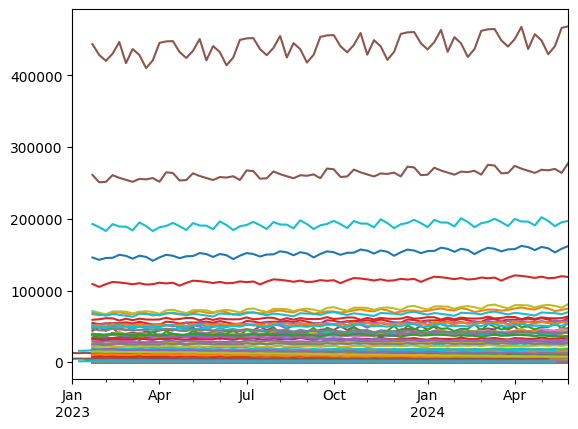

In [7]:
errores = []

def Proyeccion(cd,columnName,df3,periodos,ptrend,pseasonal,pdamped,puse,tipo):
        df10 = df3[df3[columnName] > 0]
        df10 = df10[['Periodo', columnName]]
        df10 = df10.set_index('Periodo')
     
        #df10.plot(figsize=(12, 5))
        # Analisis de descomposicion
        #components = seasonal_decompose(df10, period=8)
        #components.plot()
        # Proyeccion
        fit1 = ExponentialSmoothing(df10, seasonal_periods=periodos,trend=ptrend,seasonal=pseasonal,damped_trend=pdamped,use_boxcox=puse,initialization_method="estimated",missing="drop").fit()
        print(fit1.summary())
        # Calcula el intervalo de confianza al 95% y lo salva
        xhat = fit1.forecast(steps= pproyeccion)
        z = 1.96
        sse = fit1.sse
        predint_xminus = xhat - z * np.sqrt(sse/len(df10))
        predint_xplus  = xhat + z * np.sqrt(sse/len(df10))

        df = [predint_xminus,predint_xplus]
        df = pd.DataFrame(df)
        df = df.transpose()
        col0 = columnName + "_minimo"
        col1 = columnName + "_maximo"

        # Changing columns name with index number
        mapping = {df.columns[0]: col0, df.columns[1]: col1}
        df = df.rename(columns=mapping)

        # Salva los intervalos

        mdir = os.path.join(dir_actual, Pais)
        mfila = cd+"-"+tipo+"-"+vista + '-_intervalo_'+columnName+'.xlsx'
        dirPath = os.path.join(mdir, mfila)
        #df.to_excel(dirPath, index_label="Periodo")


        # Intervalo de confianza por simulacion
        simulations = fit1.simulate(pproyeccion, repetitions=1, error="add", random_errors=None)
        #ax = df10.plot(figsize=(12, 5),marker="o",color="black",title="Proyeccion",)
        #ax.set_ylabel("Venta")
        #ax.set_xlabel("Periodo")
        #fit1.fittedvalues.plot(ax=ax, style="--", color="green")
        #fit1.forecast(steps=pproyeccion).rename("Proyeccion").plot(ax=ax, style="--", marker="o", color="green", legend=True )


        # Grafica la serie de Ajuste y la añade a fit1
        df6 = fit1.forecast(pproyeccion)
        df6.plot()
        df7 = fit1.predict(0)

        df8 = [df7,df6]

        #df1 = (df0[[columnName]])

        df = pd.DataFrame(df8)
        df = df.transpose()
        col0 = columnName + "_ajuste"
        col1 = columnName + "_proyeccion"
        col2 = columnName 

        # Changing columns name with index number
        mapping = {df.columns[0]: col0, df.columns[1]: col1}
        df = df.rename(columns=mapping)
        df = df.fillna(0)
        df[col2] = df[col1].add(df10[columnName],fill_value=0)
        # Salva la proyeccion normal
        mdir = os.path.join(dir_actual, Pais)
        mfila = cd+"-"+tipo+"-"+ vista + '-py_'+columnName+'.xlsx'
        dirPath = os.path.join(mdir, mfila)
        df.to_excel(dirPath, index_label="Periodo")

        # Calcula el Error por medio del MAPE
        df99 = [df7]
        yy = pd.DataFrame(df99)
        yy = yy.transpose()
        xx = pd.DataFrame(df10)
        errores.append({"cd":cd+"-"+tipo+"-"+columnName,"Mape":mape(xx,yy),"wmape":wmape(xx,yy),"tipo":tipo})

def Procesamiento(df,cd,tipo):
    for (columnName, columnData) in df.items():
        #print('Column Name : ', columnName)
        #print('Column Contents : ', columnData.values)
        # Parametros personalizados
        ptrend = 'add'
        pseasonal = 'mul'
        pdamped = False
        puse = 0.7
        periodos = 12

        if (columnName != 'Periodo') :
           try:
                Proyeccion(cd,columnName,df,periodos,ptrend,pseasonal,pdamped,puse,tipo)
           except:
                Proyeccion(cd,columnName,df,4,ptrend,pseasonal,pdamped,puse,tipo)


for cd in cdlist:

    totalcds = e2s[cd]
    totalcds = totalcds.drop("Total")
    totalcdc = e2c[cd]
    totalcdc = totalcdc.drop("Total")



    dfps2 = dfproyeccioness[cd]
    dfps2 = dfps2.loc[:, dfps2.columns.isin(matstoprojects[cd])]
    dfps2['Total'] = totalcds
    dfps2['Periodo'] = pd.date_range(start="2/02/2020", periods=dfps2.shape[0], freq="W")
    dfps2.to_excel(cd +"test.xlsx", index_label="Periodo")
    Procesamiento(dfps2,cd,"Salchicha")

    dfpc2 = dfproyeccionesc[cd]
    dfpc2 = dfpc2.loc[:, dfpc2.columns.isin(matstoprojectc[cd])]
    dfpc2['Total'] = totalcdc
    dfpc2['Periodo'] = pd.date_range(start="2/02/2020", periods=dfpc2.shape[0], freq="W")
    dfpc2.to_excel(cd +"testc.xlsx", index_label="Periodo")
    Procesamiento(dfpc2,cd,"Chorizo")
    dferrores = pd.DataFrame(errores)
 


In [8]:
#Errores a excel:
mdir2 = os.path.join(dir_actual, Pais,"reportes")
mfilac = vista + '-CentroDistribucion-Chorizos-Errores.xlsx'
dirPathc = os.path.join(mdir2, mfilac)
mfilas = vista + '-CentrosDistribucion-Salchichas-Errores.xlsx'
dirPaths = os.path.join(mdir2, mfilas)
print(dferrores)
dfes = dferrores[dferrores["tipo"]== "Salchicha"]
dfec = dferrores[dferrores["tipo"]== "Chorizo"]
dfes.to_excel(dirPaths)
dfec.to_excel(dirPathc)

# Une la salida

for cd in cdlist:
    for tipo in ["Salchicha","Chorizo"]:
        df=[]

        mdir = os.path.join(dir_actual, Pais)
        mfila = os.path.join(mdir, cd +"-"+tipo+"-"+ vista + "-py*")
        files = glob.glob(mfila)
        #print(mfila)
        for a in files:
            df.append( pd.read_excel(a, sheet_name='Sheet1'))

        i = 0
        for x in df:
            if i > 0 :
                dt = pd.merge(dt, df[i])
            else :
                dt = df[0]
            i = i + 1
       
        # Salva la proyeccion final de cada serie
        mdir = os.path.join(dir_actual, Pais)
        mfila = cd+"-"+tipo+"-"+ vista + '-Reporte_Final.xlsx'
        dirPath = os.path.join(mdir2,tipo, mfila)
        dt= dt.set_index('Periodo')
        dt = dt[dt.columns.drop(list(dt.filter(regex='_ajuste')))]
        dt = dt[dt.columns.drop(list(dt.filter(regex='_proyeccion')))]
        dt2= dt.iloc[:, :-1].sum(axis=1)
        dt['A'] = dt2
        dt['B+C'] = dt['Total'] - dt['A']
        dt.insert(0, 'B+C', dt.pop('B+C'))
        dt.insert(0, 'A', dt.pop('A'))
        print(dt)
        dt.to_excel(dirPath)

      

                          cd       Mape      wmape       tipo
0    NN13-Salchicha-M1000497  15.555049  15.393769  Salchicha
1    NN13-Salchicha-M1000794  18.908002  17.432252  Salchicha
2    NN13-Salchicha-M1000820  14.809062  14.034885  Salchicha
3    NN13-Salchicha-M1000821  63.872551  27.210234  Salchicha
4    NN13-Salchicha-M1000833  16.386879  15.535789  Salchicha
..                       ...        ...        ...        ...
345  NNB8-Salchicha-M1043327   9.414740   9.084862  Salchicha
346  NNB8-Salchicha-M1043643  10.704530   9.850214  Salchicha
347  NNB8-Salchicha-M1046292   6.275106   6.323693  Salchicha
348     NNB8-Salchicha-Total   8.141344   8.119062  Salchicha
349       NNB8-Chorizo-Total  12.213618  11.080864    Chorizo

[350 rows x 4 columns]
                        A           B+C     M1000497     M1000794    M1000820  \
Periodo                                                                         
2020-02-02  119553.831000   7556.005000  1891.000000  4370.000000  489

                        A           B+C     M1000031     M1000814  \
Periodo                                                             
2020-02-02  231897.267000   4307.573000   701.195000   486.851000   
2020-02-09  247004.788000   5566.085000   834.006000   311.220000   
2020-02-16  306136.803000   7368.320000   743.755000  1717.170000   
2020-02-23  329406.427000   6674.170000   675.452000   653.380000   
2020-03-01  303871.743000   4968.291000   833.723000   673.400000   
...                   ...           ...          ...          ...   
2024-05-05  484955.077363 -36128.545121  2433.213653   550.071627   
2024-05-12  486085.640998 -56422.734360  2433.289412   585.979893   
2024-05-19  503537.774783 -62672.165278  2429.313536   567.733996   
2024-05-26  489057.302293 -22642.510846  2338.108004   562.361392   
2024-06-02  514710.431355 -46087.960799  2527.713450   542.073524   

               M1000820     M1000821     M1000833     M1000845     M1000849  \
Periodo                

                        A           B+C    M1000031    M1000814     M1000820  \
Periodo                                                                        
2020-02-02   84824.546000   8732.306000  635.000000   85.000000  2045.000000   
2020-02-09   87342.507000   8806.068000  780.750000   58.000000  2294.000000   
2020-02-16  109021.348000   9547.469000  790.750000  149.000000  3589.500000   
2020-02-23   83500.583000   6349.317000  366.250000   65.000000  1911.000000   
2020-03-01  112299.109000  10374.501000  808.000000  103.000000  3170.000000   
...                   ...           ...         ...         ...          ...   
2024-05-05  123138.442209  -3799.875650  648.907762  134.898170  3282.827304   
2024-05-12  121018.003632  -3756.144493  709.748602  131.546656  3253.965733   
2024-05-19  121788.911211  -3950.823293  706.325140  151.078353  3363.718061   
2024-05-26  124857.186234  -4819.762377  693.019727  162.956341  3345.748751   
2024-06-02  122822.694188  -3853.937512 

                       A          B+C     M1000195    M1000209      M1034258  \
Periodo                                                                        
2020-02-02  30064.950000  1134.000000  1585.000000  280.000000   5399.000000   
2020-02-09  29216.186000  1197.000000  1688.000000  366.000000   4030.000000   
2020-02-16  43017.940000  2241.000000  2948.000000  776.000000   8071.000000   
2020-02-23  36477.754000  1962.000000  2078.000000  389.000000   5800.667000   
2020-03-01  41626.172000  1930.000000  2252.000000  319.000000   7040.333000   
...                  ...          ...          ...         ...           ...   
2024-05-05  53781.336888  2395.660870  2531.202655  449.698022  11540.823056   
2024-05-12  52346.805726  2553.142950  2459.605093  426.996382  11213.247115   
2024-05-19  50825.300405  3224.362874  2435.522234  372.859411  10889.992377   
2024-05-26  52708.426779  3002.643404  2609.224626  466.683361  10935.184919   
2024-06-02  51797.961917  2580.585251  2

                       A           B+C     M1000195      M1037101  \
Periodo                                                             
2020-02-02  31885.575000  22854.726000  3745.000000  21727.575000   
2020-02-09  31800.220000  24423.394000  3705.000000  20517.970000   
2020-02-16  44447.577000  33333.220000  5042.000000  32363.577000   
2020-02-23  41277.510000  24713.343000  5539.000000  29287.510000   
2020-03-01  33807.167000  21110.227000  5033.000000  23882.667000   
...                  ...           ...          ...           ...   
2024-05-05  36497.550322  32983.219088  5126.651569  26367.386722   
2024-05-12  35607.416737  33287.491720  4745.259749  26040.297728   
2024-05-19  35513.157316  32995.359260  4650.350547  25971.447918   
2024-05-26  35052.570733  32119.530559  4690.010191  25576.100110   
2024-06-02  36918.773383  33067.691777  4692.389542  27207.789284   

               M1037102         Total  
Periodo                                
2020-02-02  6413.00000

              A          B+C        Total
Periodo                                  
2020-02-02  0.0  4620.876000  4620.876000
2020-02-09  0.0  4836.764000  4836.764000
2020-02-16  0.0  6045.986000  6045.986000
2020-02-23  0.0  5162.964000  5162.964000
2020-03-01  0.0  5791.388000  5791.388000
...         ...          ...          ...
2024-04-14  0.0  4768.350150  4768.350150
2024-04-21  0.0  4801.442409  4801.442409
2024-04-28  0.0  4683.070410  4683.070410
2024-05-05  0.0  4670.574112  4670.574112
2024-05-12  0.0  4823.090171  4823.090171

[224 rows x 3 columns]
                     A          B+C    M1037101        Total
Periodo                                                     
2020-02-02   31.000000   865.502000   31.000000   896.502000
2020-02-09   20.000000  1034.168000   20.000000  1054.168000
2020-02-16   51.000000   913.167000   51.000000   964.167000
2020-02-23   42.000000   738.750000   42.000000   780.750000
2020-03-01   51.000000   822.167000   51.000000   873.167000
...

                       ExponentialSmoothing Model Results                       
Dep. Variable:     Chorizo y Variedades   No. Observations:                  155
Model:             ExponentialSmoothing   SSE                   117381421672.741
Optimized:                         True   AIC                           3201.017
Trend:                         Additive   BIC                           3249.712
Seasonal:                Multiplicative   AICC                          3206.046
Seasonal Periods:                    12   Date:                 Fri, 14 Apr 2023
Box-Cox:                           True   Time:                         09:39:16
Box-Cox Coeff.:                 0.70000                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.6060714                alpha                 True
smoothing_trend          

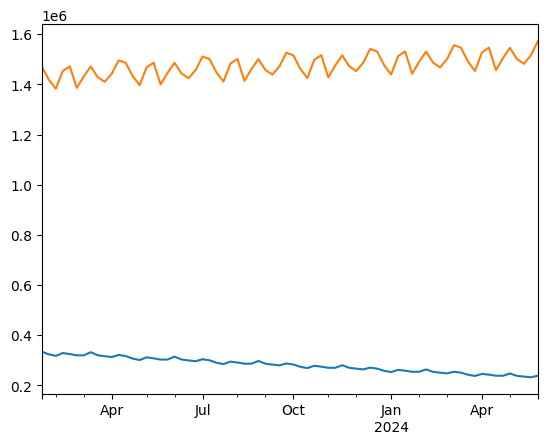

In [9]:
Procesamiento(e1,"Lineas","Proyeccion")
df=[]

mdir = os.path.join(dir_actual, Pais)
mfila = os.path.join(mdir, "Lineas-Proyeccion-CarnicosData-ini-py*")
files = glob.glob(mfila)
#print(mfila)
for a in files:
    df.append( pd.read_excel(a, sheet_name='Sheet1'))

i = 0
for x in df:
    if i > 0 :
        dt = pd.merge(dt, df[i])
    else :
        dt = df[0]
    i = i + 1
       
# Salva la proyeccion final de cada serie
mdir = os.path.join(dir_actual, Pais)
mfila = 'Lineas-Proyeccion-CarnicosData-Reporte_Final.xlsx'
dirPath = os.path.join(mdir, mfila)
dt= dt.set_index('Periodo')
dt = dt[dt.columns.drop(list(dt.filter(regex='_ajuste')))]
dt = dt[dt.columns.drop(list(dt.filter(regex='_proyeccion')))]
dt.to_excel(dirPath)